In [2]:
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader

In [3]:
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.optim import Adam

In [6]:
train_paths_parasitized = []
train_paths_uninfected = []

train_paths_parasitized += os.listdir('../data/training_set/Parasitized')

In [7]:
train_paths_parasitized[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [8]:
train_paths_parasitized = ['data/training_set/Parasitized/' + i for i in train_paths_parasitized]

In [10]:
train_paths_uninfected += os.listdir('../data/training_set/Uninfected')
train_paths_uninfected = ['data/training_set/Uninfected/' + i for i in train_paths_uninfected]

In [11]:
train_paths_uninfected[0]

'data/training_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'

In [17]:

paths = train_paths_parasitized + train_paths_uninfected
# paths.remove("cell_images/Parasitized/Thumbs.db")
# paths.remove("cell_images/Uninfected/Thumbs.db")

In [20]:
len(paths)

0

In [10]:
l=[]
for i in range(len(paths)):
    # print(i)
    image = cv2.imread(paths[i])
    if(image is None):
        l.append(i)

In [11]:
l

[13779, 27559]

In [19]:
c=0
for i in range(len(paths)):
    # print(i)
    image = cv2.imread(paths[i-c])
    if(image is None):
        paths.pop(i-c)
        c+=1

In [12]:
c=0
for i in l:
    paths.pop(i-c)
    c+=1

In [13]:
len(paths)

27558

In [14]:

random.shuffle(paths)

FRACTION = 0.8
train_paths = paths[0:int(FRACTION*len(paths))]
val_paths = paths[int(FRACTION*len(paths)):]
print(len(val_paths), len(train_paths))

5512 22046


In [15]:
train_paths[:10]

['data/training_set/Parasitized/C50P11thinF_IMG_20150724_120716_cell_152.png',
 'data/training_set/Parasitized/C91P52ThinF_IMG_20150821_123116_cell_176.png',
 'data/training_set/Parasitized/C52P13thinF_IMG_20150725_124830_cell_177.png',
 'data/training_set/Uninfected/C88P49ThinF_IMG_20150820_150141_cell_5.png',
 'data/training_set/Uninfected/C2NThinF_IMG_20150604_114751_cell_107.png',
 'data/training_set/Uninfected/C229ThinF_IMG_20151112_144652_cell_191.png',
 'data/training_set/Uninfected/C48P9thinF_IMG_20150721_161412_cell_141.png',
 'data/training_set/Uninfected/C119P80ThinF_IMG_20151002_124345_cell_84.png',
 'data/training_set/Uninfected/C81P42ThinF_IMG_20150817_121113_cell_154.png',
 'data/training_set/Uninfected/C111P72ThinF_IMG_20150930_113610_cell_198.png']

In [16]:
train_paths[0].split('/')[2]

'Parasitized'

In [17]:
class Malaria(Dataset):
  def __init__(self, image_filepaths, transform = None):
    self.image_filepaths = image_filepaths
    self.transform = transform

  def __len__(self):
    return len(self.image_filepaths)

  def __getitem__(self, index):

    image = cv2.imread(self.image_filepaths[index])

    if(self.image_filepaths[index].split('/')[2] == 'Parasitized'):
      label = 0.0
    else:
      label = 1.0


    if self.transform:
      image_pil = Image.fromarray(image)
      image = self.transform(image_pil)
      image=image.detach().numpy()
      image=np.transpose(image, (1, 2, 0))
    return image, label


In [18]:
IM_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomRotation(degrees=(0, 90)),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Assuming RGB normalization
])


In [19]:
train_dataset = Malaria(train_paths, transform)
val_dataset = Malaria(val_paths, transform)

In [20]:
# for i in range(22049):
#     if(train_dataset.__getitem__(1)[0].any()==None):
#         print(i)
    

In [21]:
train_dataset.__getitem__(1)[0].shape

(224, 224, 3)

In [22]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [23]:
image, label = next(iter(train_loader))
print(image[1][100:150,100:150,0])

tensor([[0.3823, 0.3823, 0.3823,  ..., 0.2967, 0.2967, 0.2967],
        [0.3823, 0.3823, 0.3823,  ..., 0.2967, 0.2967, 0.2967],
        [0.3994, 0.3994, 0.3994,  ..., 0.2967, 0.2967, 0.2796],
        ...,
        [0.3138, 0.2967, 0.2967,  ..., 0.2624, 0.2624, 0.2796],
        [0.3138, 0.2967, 0.2967,  ..., 0.2624, 0.2796, 0.2796],
        [0.2967, 0.2796, 0.2967,  ..., 0.2796, 0.2796, 0.2796]])


In [24]:
image.shape

torch.Size([32, 224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.454815].


tensor(1., dtype=torch.float64)


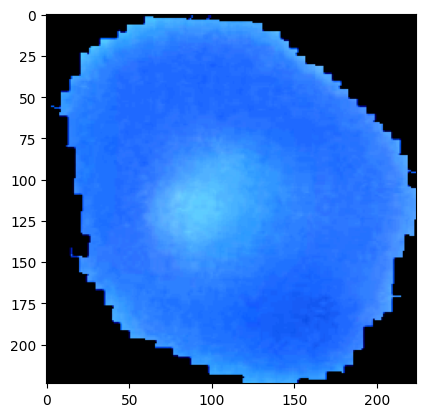

In [25]:
plt.imshow(image[0])
print(label[0])

In [26]:
image[0].shape

torch.Size([224, 224, 3])

In [27]:
image[0].view(-1, 16 * 56 * 56).shape

torch.Size([3, 50176])

In [28]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2),
            nn.Conv2d(6, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 56 * 56, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
            nn.ReLU(),
            nn.BatchNorm1d(10),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.reshape(-1, 16 * 56 * 56)  # Reshape for the fully connected layer
        x = self.classifier(x)
        return x

In [29]:
model = LeNet()

op=model(torch.zeros((3,3,224,224)))


In [30]:
op.shape

torch.Size([3, 1])

In [31]:
op.data

tensor([[0.5553],
        [0.5553],
        [0.5553]])

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = torch.nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

In [33]:
device

device(type='cuda', index=0)

In [34]:
def round(x):
  if(x>= 0.5):
    return 1.
  else:
    return 0.

In [35]:
def get_accuracy(epoch):
  model.eval()
  with torch.no_grad():
    epoch_accuracy = 0
    for i, (image, label) in enumerate(val_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      output = model(image)

      for i in range(len(output)):
        if(round(output[i].item()) == label[i].item()):
          epoch_accuracy += 1

  print("The Validation Accuracy for this epoch:{} is:{} ".format(epoch, 100*epoch_accuracy/len(val_dataset)))

In [36]:
t,f=0,0

In [37]:
label

tensor([1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
       dtype=torch.float64)

In [38]:
for i, (image, label) in enumerate(train_loader):
    l=label.tolist()
    f+=l.count(0.0)
    t+=l.count(1.0)

In [39]:
f

10959

In [40]:
t

11087

In [41]:
def train(EPOCHS):

  model.to(device)

  for epoch in range(EPOCHS):
    epoch_loss = 0.0

    for i, (image, label) in enumerate(train_loader):
      image = torch.permute(image, (0,3,1,2))
      image = image.to(device)

      label = torch.unsqueeze(label, -1)
      label = label.float()
      label = label.to(device)

      optimizer.zero_grad()

      output = model(image)

      loss = loss_fn(output, label)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()

      step_length = int(len(train_loader)/2)

      if(i%step_length) == 0:
              print('Epoch Number: {}, step: [{}|{}] ----> Loss: {}' .format(epoch+1, i, len(train_loader), loss.item()))
    print("Loss for epoch Number {} is :{}".format(epoch+1, epoch_loss/len(train_loader)))

    get_accuracy(epoch)


In [42]:
train(20)

Epoch Number: 1, step: [0|689] ----> Loss: 0.6880611777305603
Epoch Number: 1, step: [344|689] ----> Loss: 0.5554466247558594
Epoch Number: 1, step: [688|689] ----> Loss: 0.39528417587280273
Loss for epoch Number 1 is :0.49717059452492196
The Validation Accuracy for this epoch:0 is:89.9310595065312 
Epoch Number: 2, step: [0|689] ----> Loss: 0.2410815954208374
Epoch Number: 2, step: [344|689] ----> Loss: 0.26071465015411377
Epoch Number: 2, step: [688|689] ----> Loss: 0.1886192262172699
Loss for epoch Number 2 is :0.2091348308675175
The Validation Accuracy for this epoch:1 is:93.59579100145137 
Epoch Number: 3, step: [0|689] ----> Loss: 0.21463948488235474
Epoch Number: 3, step: [344|689] ----> Loss: 0.17446297407150269
Epoch Number: 3, step: [688|689] ----> Loss: 0.21713365614414215
Loss for epoch Number 3 is :0.1830833429830211
The Validation Accuracy for this epoch:2 is:93.95863570391872 
Epoch Number: 4, step: [0|689] ----> Loss: 0.2714366912841797
Epoch Number: 4, step: [344|689] 

KeyboardInterrupt: 

In [62]:
image = cv2.imread('data/single_prediction/Parasitised.png')

In [63]:
image.shape

(142, 139, 3)

In [ ]:
image_pil = Image.fromarray(image)
image = transform(image_pil)
image=image.detach().numpy()
image = image[None, :, :, :]
image=torch.tensor(image)

In [85]:
image.shape

torch.Size([1, 3, 224, 224])

In [66]:
# image = torch.permute(image, (0,3,1,2))

In [67]:
image = image.to(device)

In [68]:
image.shape

torch.Size([1, 3, 224, 224])

In [71]:
# for i, (image, label) in enumerate(train_loader):
#       image = torch.permute(image, (0,3,1,2))
#     #   image = image.to(device)
#       print(image.shape)
#       break


In [72]:
dummy_input=torch.randn(1, 3, 224, 224)
dummy_input=dummy_input.to(device)
torch.onnx.export(model, dummy_input, 'models/Lenet_malaria_detection.onnx', export_params=True, opset_version=11, do_constant_folding=True)

In [122]:
torch.save(model, "models/LenetMalariaDetection.pth")

In [125]:
torch.save(model.state_dict(), "models/model_state.pth")

In [127]:
saved_model = torch.load('models/LenetMalariaDetection.pth')
saved_model.eval()

C:\Users\VAMSI\AppData\Local\Temp\ipykernel_21272\3103072623.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_model = torch.load('models/LenetMalariaDetection.pth')

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_featur

In [113]:
op=model(image)

In [115]:
image.shape

torch.Size([1, 3, 224, 224])

In [116]:
dummy_input.shape

torch.Size([1, 3, 224, 224])

In [114]:
op

tensor([[0.0009]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [74]:
import onnx
from onnx2pytorch import ConvertModel

In [105]:
onnx_model = onnx.load("models/Lenet_malaria_detection.onnx")

pytorch_model = ConvertModel(onnx_model)

In [93]:
image.size()

torch.Size([1, 3, 224, 224])

In [94]:
# pytorch_model.eval()

In [77]:
cudaimage=image.to(device)

In [95]:
non_cuda_image = cv2.imread('data/single_prediction/Parasitised.png')

In [96]:
non_cuda_image_pil = Image.fromarray(non_cuda_image)
non_cuda_image = transform(non_cuda_image_pil)
non_cuda_image=non_cuda_image.detach().numpy()
non_cuda_image = non_cuda_image[None, :, :, :]
non_cuda_image=torch.tensor(non_cuda_image)

In [103]:
non_cuda_image.shape

torch.Size([1, 3, 224, 224])

In [104]:
image.shape

torch.Size([1, 3, 224, 224])

In [112]:
model(image)

tensor([[0.0009]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [111]:
pytorch_model(image)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])

In [118]:
model.eval()

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
    (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_featur

In [119]:
pytorch_model.eval()

ConvertModel(
  (Conv_/feature_extractor/feature_extractor.0/Conv_output_0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_/feature_extractor/feature_extractor.1/Relu_output_0): ReLU(inplace=True)
  (BatchNormalization_/feature_extractor/feature_extractor.2/BatchNormalization_output_0): BatchNormWrapper(
    (bnu): BatchNormUnsafe(6, eps=9.999999747378752e-06, momentum=0.8999999761581421, affine=True, track_running_stats=True)
  )
  (MaxPool_/feature_extractor/feature_extractor.3/MaxPool_output_0): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  (Conv_/feature_extractor/feature_extractor.5/Conv_output_0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Relu_/feature_extractor/feature_extractor.6/Relu_output_0): ReLU(inplace=True)
  (BatchNormalization_/feature_extractor/feature_extractor.7/BatchNormalization_output_0): BatchNormWrapper(
    (bnu): BatchNormUnsafe(16, eps=9.999999747378752e-06

In [107]:
cuda_model_onnx=pytorch_model.to(device)

In [108]:
cudaimage=non_cuda_image.to(device)

In [117]:
pytorch_model(cudaimage)

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 100])